In [ ]:
!pip -q install numpy pandas scikit-learn matplotlib

In [ ]:
import pandas as pd

DATASET = "glass"  # choices: "glass" or "pendigits"

if DATASET == "glass":
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
    cols = [
        "Id",
        "RI",        # refractive index
        "Na",        # Sodium
        "Mg",        # Magnesium
        "Al",        # Aluminum
        "Si",        # Silicon
        "K",         # Potassium
        "Ca",        # Calcium
        "Ba",        # Barium
        "Fe",        # Iron
        "class"      # Glass type (multi-class target)
    ]
    df = pd.read_csv(url, header=None, names=cols)
    df.drop(columns=["Id"], inplace=True)  # Drop Id column (not a feature)
    csv_path = "glass.csv"; target_col = "class"

elif DATASET == "pendigits":
    train = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"
    test  = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tes"
    cols = [f"f{i}" for i in range(16)] + ["digit"]
    df = pd.concat([
        pd.read_csv(train, header=None, names=cols),
        pd.read_csv(test,  header=None, names=cols)
    ], ignore_index=True)
    csv_path = "pendigits.csv"; target_col = "digit"

else:
    raise ValueError("Unknown DATASET")

df.to_csv(csv_path, index=False)
print(f"Saved {df.shape} to {csv_path}. Target column = {target_col}")
df.head()


Saved (214, 10) to glass.csv. Target column = class


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [ ]:
import os, json, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

# ------------ FAST PRESET -------------
CSV = csv_path              # from the download cell
TARGET = target_col
OUT_DIR = "svm_results_fast"
N_SAMPLES = 10
ITERS = 100
KERNELS = ["linear", "rbf"]
PATIENCE = 12               # early stop if no improvement for 12 iters
CACHE_MB = 1024             # bigger kernel cache
NU_RANGE = (0.05, 0.95)
TOL_RANGE = (1e-5, 1e-3)    # acts as “epsilon” field in your table
SEEDS = [11,22,33,44,55,66,77,88,99,111]


os.makedirs(OUT_DIR, exist_ok=True)

# ---------- load ----------
data = pd.read_csv(CSV)
X_df = data.drop(columns=[TARGET])
y = data[TARGET]
tt = type_of_target(y)
if tt not in ("multiclass", "multiclass-indicator"):
    raise ValueError(f"Target must be multiclass; got {tt}")

if not (5000 <= len(data) <= 30000):
    print(f"Warning: dataset has {len(data)} rows (assignment asks 5k–30k). Proceeding anyway.")

def sample_params(rng):
    kernel = rng.choice(KERNELS)
    nu = float(rng.uniform(*NU_RANGE))
    tol = float(10 ** rng.uniform(math.log10(TOL_RANGE[0]), math.log10(TOL_RANGE[1])))
    params = {"kernel": kernel, "nu": nu, "tol": tol, "cache_size": CACHE_MB, "shrinking": True}
    if kernel in ("rbf", "sigmoid"):
        params["gamma"] = rng.choice(["scale","auto"])
    if kernel == "poly":
        params["degree"] = rng.integers(2,6)
        params["gamma"] = rng.choice(["scale","auto"])
        params["coef0"] = float(rng.uniform(0.0, 1.0))
    return params

summary_rows, all_curves = [], {}
start_all = time.time()

for i, seed in enumerate(SEEDS[:N_SAMPLES], start=1):
    S = f"S{i}"
    rng = np.random.default_rng(seed)

    # Split once per sample
    X_tr_df, X_te_df, y_tr, y_te = train_test_split(
        X_df, y, test_size=0.30, stratify=y, random_state=seed
    )

    # Scale ONCE per split (faster than fitting a Pipeline every loop)
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_df).astype(np.float32)
    X_te = scaler.transform(X_te_df).astype(np.float32)

    best_acc = -1.0
    best_params = None
    curve = []
    no_improve = 0
    start_s = time.time()

    for it in range(1, ITERS+1):
        params = sample_params(rng)
        try:
            clf = NuSVC(**params)
            clf.fit(X_tr, y_tr)
            acc = accuracy_score(y_te, clf.predict(X_te))
        except Exception:
            acc = 0.0

        if acc > best_acc + 1e-6:
            best_acc = acc
            best_params = params
            no_improve = 0
        else:
            no_improve += 1

        curve.append(best_acc)

        # Early stopping
        if no_improve >= PATIENCE:
            # pad curve to keep length the same (optional)
            curve += [best_acc] * (ITERS - len(curve))
            break

    all_curves[S] = curve

    kernel = best_params["kernel"]
    nu = round(best_params["nu"], 4)
    epsilon = round(best_params["tol"], 6)

    summary_rows.append({
        "Sample #": S,
        "Best Accuracy": round(best_acc*100, 2),
        "Kernel": kernel,
        "Nu": nu,
        "Epsilon": epsilon,
        "Best SVM Parameters (JSON)": json.dumps(best_params, sort_keys=True)
    })

    dur = time.time() - start_s
    print(f"{S}: acc={best_acc:.4f} kernel={kernel} nu={nu} eps={epsilon} "
          f"(iters={len(curve)}/{ITERS}, {dur:.1f}s)")

summary = pd.DataFrame(summary_rows).sort_values("Sample #")
summary_path = os.path.join(OUT_DIR, "optimized_svm_summary.csv")
summary.to_csv(summary_path, index=False)
print(f"\nSaved table to: {summary_path}  | total time ≈ {time.time()-start_all:.1f}s")
summary


S1: acc=0.6462 kernel=rbf nu=0.1742 eps=0.000377 (iters=100/100, 0.0s)
S2: acc=0.6923 kernel=rbf nu=0.0737 eps=0.000769 (iters=100/100, 0.0s)
S3: acc=0.7077 kernel=rbf nu=0.0639 eps=0.000351 (iters=100/100, 0.0s)
S4: acc=0.7077 kernel=rbf nu=0.0675 eps=0.000393 (iters=100/100, 0.0s)
S5: acc=0.7231 kernel=rbf nu=0.0642 eps=4.9e-05 (iters=100/100, 0.1s)
S6: acc=0.7231 kernel=rbf nu=0.1742 eps=0.000291 (iters=100/100, 0.0s)
S7: acc=0.6923 kernel=rbf nu=0.1677 eps=5.2e-05 (iters=100/100, 0.0s)
S8: acc=0.7077 kernel=rbf nu=0.1635 eps=9.7e-05 (iters=100/100, 0.0s)
S9: acc=0.3846 kernel=linear nu=0.1518 eps=3.6e-05 (iters=100/100, 0.0s)
S10: acc=0.6615 kernel=linear nu=0.2024 eps=0.000103 (iters=100/100, 0.0s)

Saved table to: svm_results_fast/optimized_svm_summary.csv  | total time ≈ 0.5s


,Sample #,Best Accuracy,Kernel,Nu,Epsilon,Best SVM Parameters (JSON)
0,S1,64.62,rbf,0.1742,0.000377,"{""cache_size"": 1024, ""gamma"": ""scale"", ""kernel..."
9,S10,66.15,linear,0.2024,0.000103,"{""cache_size"": 1024, ""kernel"": ""linear"", ""nu"":..."
1,S2,69.23,rbf,0.0737,0.000769,"{""cache_size"": 1024, ""gamma"": ""auto"", ""kernel""..."
2,S3,70.77,rbf,0.0639,0.000351,"{""cache_size"": 1024, ""gamma"": ""scale"", ""kernel..."
3,S4,70.77,rbf,0.0675,0.000393,"{""cache_size"": 1024, ""gamma"": ""auto"", ""kernel""..."
4,S5,72.31,rbf,0.0642,0.000049,"{""cache_size"": 1024, ""gamma"": ""auto"", ""kernel""..."
5,S6,72.31,rbf,0.1742,0.000291,"{""cache_size"": 1024, ""gamma"": ""auto"", ""kernel""..."
6,S7,69.23,rbf,0.1677,0.000052,"{""cache_size"": 1024, ""gamma"": ""auto"", ""kernel""..."
7,S8,70.77,rbf,0.1635,0.000097,"{""cache_size"": 1024, ""gamma"": ""scale"", ""kernel..."
8,S9,38.46,linear,0.1518,0.000036,"{""cache_size"": 1024, ""kernel"": ""linear"", ""nu"":..."


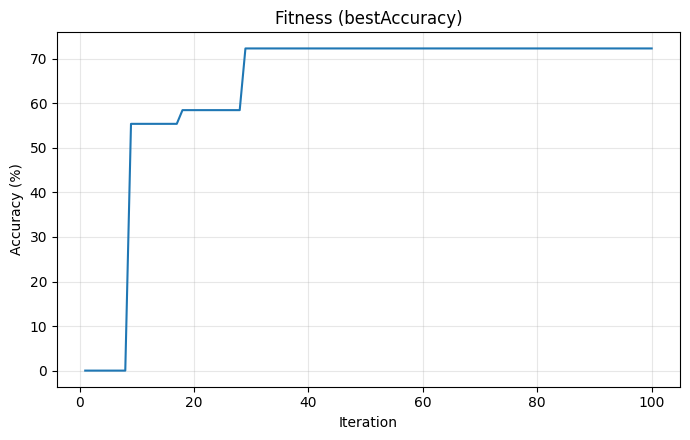

Saved convergence plot to: svm_results_fast/convergence_S5.png


In [ ]:
best_idx = int(np.argmax(summary["Best Accuracy"].values))
best_sample = summary.iloc[best_idx]["Sample #"]
best_curve = all_curves[best_sample]

plt.figure(figsize=(7,4.5))
plt.plot(range(1, len(best_curve)+1), [v*100 for v in best_curve])
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.title("Fitness (bestAccuracy)")
plt.grid(True, alpha=0.3)
plot_path = os.path.join(OUT_DIR, f"convergence_{best_sample}.png")
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
plt.show()

print(f"Saved convergence plot to: {plot_path}")
